# MLPRegressor

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from statsmodels.tools.eval_measures import stde

import kerastuner as kt
import tensorflow as tf
from tensorflow.keras import models


2022-11-21 13:39:40.840885: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-21 13:39:40.957680: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-21 13:39:41.368404: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/nkspartan/miniconda3/envs/tf-gpu/lib/
2022-11-21 13:39:41.368468: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfe

In [2]:
from tensorflow.python.client import device_lib

print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Default GPU Device: /device:GPU:0


2022-11-21 13:39:41.829691: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-21 13:39:41.852867: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 13:39:41.857474: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 13:39:41.857672: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

## Read the etl info results

In [3]:
df_info = pd.read_csv('../dataset_clean/options_csv_v1_etl.csv')
df_info

,remove_time_features,generic_features,remove_atypical_values,feature_combination,remove_feature_selection,remove_invalid_correlated_features
0,False,False,False,False,False,False


## Read the dataset

In [4]:
df = pd.read_csv('../dataset/V2_PlatteRiverWeir_features_merged_all.csv')
df

,Unnamed: 0.1,Unnamed: 0,SensorTime,CaptureTime,Filename,Agency,SiteNumber,TimeZone,Stage,Discharge,...,WwRawLineMin,WwRawLineMax,WwRawLineMean,WwRawLineSigma,WwCurveLineMin,WwCurveLineMax,WwCurveLineMean,WwCurveLineSigma,RiverArea,RiverWidth
0,0,0,2012-06-09 13:15:00,2012-06-09T13:09:07,statelineweir_20120609_farrell_001.jpg,USGS,6674500,MDT,2.99,916.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,49975.0,207.508733
1,1,1,2012-06-09 13:15:00,2012-06-09T13:10:29,statelineweir_20120609_farrell_002.jpg,USGS,6674500,MDT,2.99,916.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,50184.0,208.663145
2,2,2,2012-06-09 13:45:00,2012-06-09T13:44:01,statelineweir_20120609_farrell_003.jpg,USGS,6674500,MDT,2.96,873.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,50543.0,209.445067
3,3,3,2012-06-09 14:45:00,2012-06-09T14:44:30,statelineweir_20120609_farrell_004.jpg,USGS,6674500,MDT,2.94,846.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,50856.0,211.265690
4,4,4,2012-06-09 15:45:00,2012-06-09T15:44:59,statelineweir_20120609_farrell_005.jpg,USGS,6674500,MDT,2.94,846.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,51004.0,211.250274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42054,42054,42054,2019-10-11 09:00:00,2019-10-11T08:59:53,statelineweir_20191011_farrell_409.jpg,USGS,6674500,MDT,2.54,434.0,...,9284.0,77521.0,38385.370066,15952.029728,0.0,70085.0,37550.894823,16444.401209,45842.0,194.934605
42055,42055,42055,2019-10-11 10:00:00,2019-10-11T09:59:52,statelineweir_20191011_farrell_410.jpg,USGS,6674500,MDT,2.54,434.0,...,10092.0,74614.0,40162.989292,15467.708856,0.0,70061.0,39397.339095,16009.008049,42300.0,194.762264
42056,42056,42056,2019-10-11 11:00:00,2019-10-11T10:59:52,statelineweir_20191011_farrell_411.jpg,USGS,6674500,MDT,2.54,434.0,...,7067.0,83260.0,42095.946590,16770.357949,0.0,76335.0,41350.006568,17489.374617,41080.0,196.480105
42057,42057,42057,2019-10-11 12:00:00,2019-10-11T11:59:53,statelineweir_20191011_farrell_412.jpg,USGS,6674500,MDT,2.54,434.0,...,6283.0,83045.0,45345.490954,17498.432849,0.0,78882.0,44553.920296,18268.294896,40976.0,193.595245


In [5]:
df['SensorTime'] = pd.to_datetime(df['SensorTime'])
df['Year'] = df['SensorTime'].dt.year
df['Month'] = df['SensorTime'].dt.month
df['date_offset'] = (df.SensorTime.dt.month * 100 + df.SensorTime.dt.day - 320)%1300

df['Season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                      labels=['spring', 'summer', 'autumn', 'winter'])

In [6]:
df = df[["CaptureTime", "SensorTime", "Stage", "Discharge", "RiverArea", "RiverWidth", "Month", "Season", "Year"]]
df

,CaptureTime,SensorTime,Stage,Discharge,RiverArea,RiverWidth,Month,Season,Year
0,2012-06-09T13:09:07,2012-06-09 13:15:00,2.99,916.0,49975.0,207.508733,6,spring,2012
1,2012-06-09T13:10:29,2012-06-09 13:15:00,2.99,916.0,50184.0,208.663145,6,spring,2012
2,2012-06-09T13:44:01,2012-06-09 13:45:00,2.96,873.0,50543.0,209.445067,6,spring,2012
3,2012-06-09T14:44:30,2012-06-09 14:45:00,2.94,846.0,50856.0,211.265690,6,spring,2012
4,2012-06-09T15:44:59,2012-06-09 15:45:00,2.94,846.0,51004.0,211.250274,6,spring,2012
...,...,...,...,...,...,...,...,...,...
42054,2019-10-11T08:59:53,2019-10-11 09:00:00,2.54,434.0,45842.0,194.934605,10,autumn,2019
42055,2019-10-11T09:59:52,2019-10-11 10:00:00,2.54,434.0,42300.0,194.762264,10,autumn,2019
42056,2019-10-11T10:59:52,2019-10-11 11:00:00,2.54,434.0,41080.0,196.480105,10,autumn,2019
42057,2019-10-11T11:59:53,2019-10-11 12:00:00,2.54,434.0,40976.0,193.595245,10,autumn,2019


In [7]:
df.dtypes

CaptureTime            object
SensorTime     datetime64[ns]
Stage                 float64
Discharge             float64
RiverArea             float64
RiverWidth            float64
Month                   int64
Season               category
Year                    int64
dtype: object

### Remove outliers

In [8]:
df = df[df.Stage > 0]
df = df[df.Discharge > 0]
df.shape

(40148, 9)

In [9]:
df = df[df.RiverWidth > 0]
#df = df[df.Discharge > 0]
df.shape

(40142, 9)

### Remove winter

In [10]:
#df = df[df.Season != "winter"]

In [11]:
df.isna().sum()

CaptureTime      0
SensorTime       0
Stage            0
Discharge        0
RiverArea        0
RiverWidth       0
Month            0
Season         126
Year             0
dtype: int64

## Divide dataset to X and Y

In [12]:
np.random.seed(0)

df_train = df[(df.Year >= 2012) & (df.Year <= 2016)]
df_train = df_train.iloc[np.random.permutation(len(df_train))]

df_val = df[(df.Year >= 2017) & (df.Year <= 2017)]
df_val = df_val.iloc[np.random.permutation(len(df_val))]

df_test = df[(df.Year >= 2018) & (df.Year <= 2019)]

In [13]:
df_train = df_train.drop(columns=["Year", "SensorTime", "CaptureTime"])
df_val = df_val.drop(columns=["Year", "SensorTime", "CaptureTime"])
df_test = df_test.drop(columns=["Year", "SensorTime", "CaptureTime"])

In [14]:

y_train = df_train[["Stage"]].values
X_train = df_train[["RiverWidth", "Month"]].values

y_val = df_train[["Stage"]].values
X_val = df_train[["RiverWidth", "Month"]].values

y_test = df_test[["Stage"]].values
X_test = df_test[["RiverWidth", "Month"]].values


In [15]:
print(X_train.shape)
print(y_train.shape)

(20304, 2)
(20304, 1)


In [16]:
input_shape = X_train.shape[1]
output_shape = y_train.shape[1]

print(input_shape, output_shape)

2 1


## Train model

In [17]:
def model_builder(lr):
  model = tf.keras.Sequential()
  model.add(tf.keras.Input(shape=input_shape))
  
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512

  model.add(tf.keras.layers.Dense(32, activation="tanh"))
  model.add(tf.keras.layers.Dense(64, activation="tanh"))
  model.add(tf.keras.layers.Dense(128, activation="tanh"))
  model.add(tf.keras.layers.Dense(64, activation="tanh"))
  """model.add(tf.keras.layers.Dense(256, activation="tanh"))
  model.add(tf.keras.layers.Dense(512, activation="tanh"))
  model.add(tf.keras.layers.Dense(512, activation="tanh"))
  model.add(tf.keras.layers.Dense(256, activation="tanh"))
  model.add(tf.keras.layers.Dense(256, activation="tanh"))
  model.add(tf.keras.layers.Dense(128, activation="tanh"))
  model.add(tf.keras.layers.Dense(64, activation="tanh"))
  model.add(tf.keras.layers.Dense(32, activation="tanh"))"""


  model.add(tf.keras.layers.Dense(output_shape, activation = 'linear'))

  
  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr), loss = 'mae', metrics = ['mse', tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mae', 'mape'])
  
  return model

In [18]:
model = model_builder(1e-3)

2022-11-21 13:39:43.144697: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 13:39:43.145050: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 13:39:43.145285: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 13:39:43.145607: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 13:39:43.145769: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

In [19]:
import datetime

date_actual = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/" + date_actual
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f"model_weights/{date_actual}_mlp_best_weights.hdf5",
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True)

In [20]:
model.fit(X_train, y_train, epochs = 1000, batch_size = 64, validation_data = (X_val, y_val), callbacks=[checkpoint_callback, es_callback, tf.keras.callbacks.ReduceLROnPlateau(patience=40)])

Epoch 1/1000
308/318 [============================>.] - ETA: 0s - loss: 0.5180 - mse: 0.7720 - rmse: 0.8786 - mae: 0.5180 - mape: 15.8458
Epoch 1: val_loss improved from inf to 0.43083, saving model to model_weights/20221121-133943_mlp_best_weights.hdf5
318/318 [==============================] - 2s 3ms/step - loss: 0.5155 - mse: 0.7675 - rmse: 0.8761 - mae: 0.5155 - mape: 15.7744 - val_loss: 0.4308 - val_mse: 0.6613 - val_rmse: 0.8132 - val_mae: 0.4308 - val_mape: 12.7185 - lr: 0.0010
Epoch 2/1000
296/318 [==========================>...] - ETA: 0s - loss: 0.4407 - mse: 0.6659 - rmse: 0.8160 - mae: 0.4407 - mape: 13.1070
Epoch 2: val_loss improved from 0.43083 to 0.41631, saving model to model_weights/20221121-133943_mlp_best_weights.hdf5
318/318 [==============================] - 1s 3ms/step - loss: 0.4390 - mse: 0.6651 - rmse: 0.8155 - mae: 0.4390 - mape: 13.0348 - val_loss: 0.4163 - val_mse: 0.6118 - val_rmse: 0.7822 - val_mae: 0.4163 - val_mape: 12.5033 - lr: 0.0010
Epoch 3/1000
309

## Test model

In [21]:
print(date_actual)

20221121-133943


In [22]:
best_model = models.load_model(f'model_weights/{date_actual}_mlp_best_weights.hdf5')

In [23]:
best_model.evaluate(X_test, y_test)


398/398 [==============================] - 1s 1ms/step - loss: 0.3074 - mse: 0.2642 - rmse: 0.5140 - mae: 0.3074 - mape: 10.6937


[0.3073977828025818,
 0.26420512795448303,
 0.5140088796615601,
 0.3073977828025818,
 10.693668365478516]

In [24]:
y_pred = best_model.predict(X_test)

398/398 [==============================] - 0s 683us/step


In [25]:
print("R^2: ", r2_score(y_test, y_pred))
print("mse: ", mean_squared_error(y_test, y_pred))
print("rmse: ", mean_squared_error(y_test, y_pred, squared=False))
print("mae: ", mean_absolute_error(y_test, y_pred))
print("mape: ", mean_absolute_percentage_error(y_test, y_pred))
print("Error estandar: ", stde(y_test.squeeze(),
      y_pred.squeeze(), ddof=2))


R^2:  0.3238037470474958
mse:  0.2642050242898822
rmse:  0.5140087784171417
mae:  0.30739782162258417
mape:  0.10693670950678061
Error estandar:  0.5099678415178749


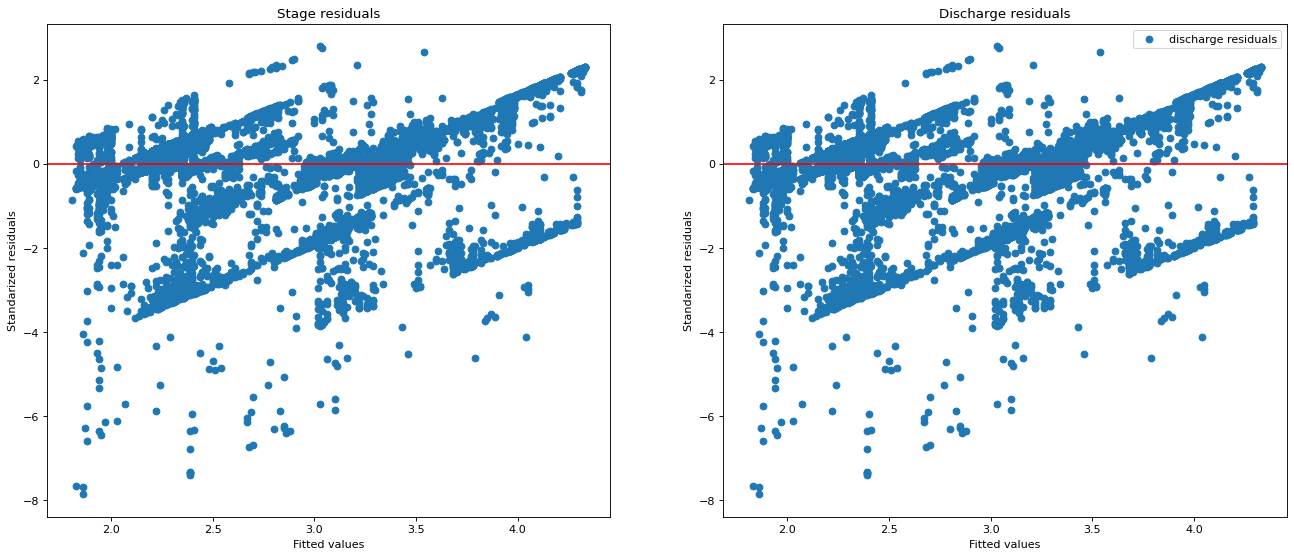

In [26]:
residuals = y_test - y_pred
residuals_std = residuals/residuals.std()

y_real_stage = np.array([i[0] for i in y_test])
residual_stage = np.array([i[0] for i in residuals])

y_real_discharge = np.array([i[-1] for i in y_test])
residual_discharge = np.array([i[-1] for i in residuals])


figure, ax = plt.subplots(ncols=2, figsize=(20, 8), dpi=80)

ax[0].scatter(y_real_stage, residual_stage / residual_stage.std(), label="stage residuals")
ax[1].scatter(y_real_discharge, residual_discharge / residual_discharge.std(), label="discharge residuals")
ax[0].axhline(y=0.0, color='r', linestyle='-')
ax[1].axhline(y=0.0, color='r', linestyle='-')

ax[0].set_title("Stage residuals")
ax[1].set_title("Discharge residuals")

ax[1].set_xlabel("Fitted values")
ax[0].set_xlabel("Fitted values")
ax[1].set_ylabel("Standarized residuals")
ax[0].set_ylabel("Standarized residuals")

plt.legend()
plt.show()

In [27]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import normal_ad

#figure = sm.qqplot(residual_stage / residual_stage.std(), line ='45', label='stage')
plt.show()

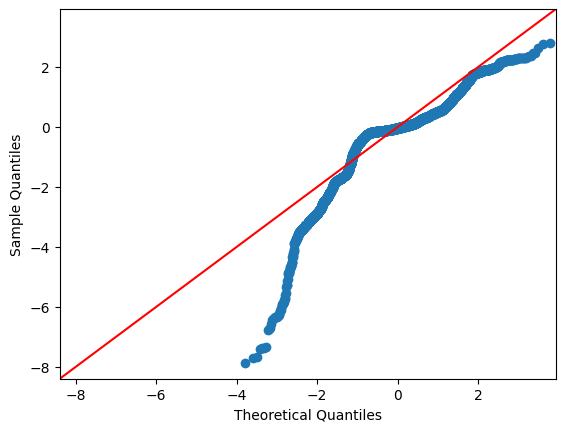

In [28]:
figure = sm.qqplot(residual_discharge / residual_discharge.std(), line='45', label='discharge')
plt.show()

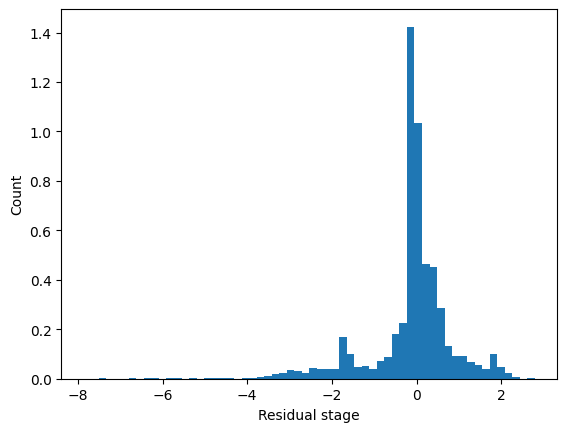

In [29]:
plt.hist(residual_stage / residual_stage.std(), density=True, bins = 60)
plt.ylabel('Count')
plt.xlabel('Residual stage');
plt.show()

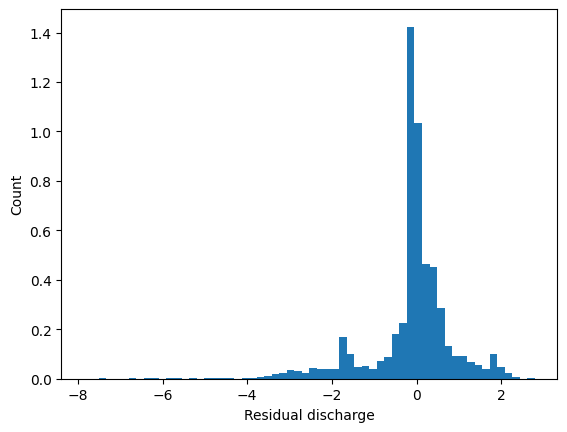

In [30]:
plt.hist(residual_discharge / residual_discharge.std(), density=True, bins = 60)
plt.ylabel('Count')
plt.xlabel('Residual discharge');
plt.show()

In [31]:
stat, pval = normal_ad(residual_discharge / residual_discharge.std())
print("p-value:", pval)

if pval < 0.05:
    print("Hay evidencia de que los residuos no provienen de una distribución normal.")
else:
    print("No hay evidencia para rechazar la hipótesis de que los residuos vienen de una distribución normal.")


p-value: 0.0
Hay evidencia de que los residuos no provienen de una distribución normal.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


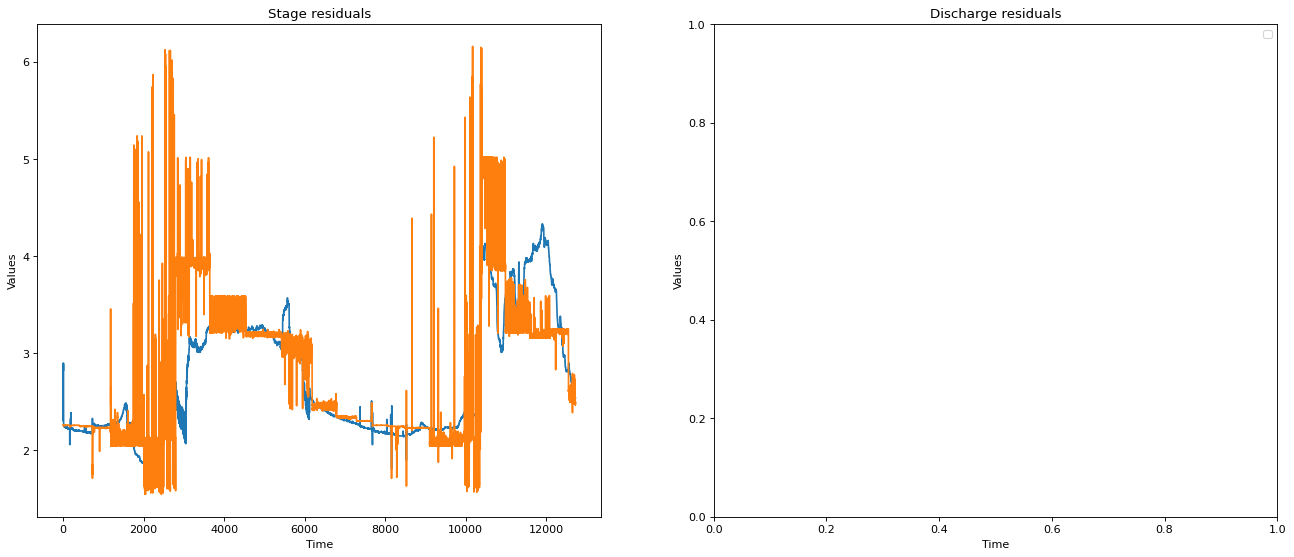

In [32]:
figure, ax = plt.subplots(ncols=2, figsize=(20, 8), dpi=80)

ax[0].plot(np.arange(len(y_test)), y_test, label="Stage real")
ax[0].plot(np.arange(len(y_test)), y_pred, label="Stage pred")

ax[0].set_title("Stage residuals")
ax[1].set_title("Discharge residuals")

ax[1].set_ylabel("Values")
ax[0].set_ylabel("Values")
ax[1].set_xlabel("Time")
ax[0].set_xlabel("Time")

plt.legend()
plt.show()